In [1]:
import h2o
import json
import utils
import transform
import train
import configs.base_config as C
import evaluate
import pandas as pd


# Start H2O
h2o.init(verbose=False)


In [2]:
# Specify model to train
model_name = "xgboost"


In [3]:
# Define model parameters
model_parameters = json.load(open(f"{C.CONFIG_DIR}{model_name}.json", "r"))


In [4]:
# Load dataset
data = utils.load_data(C.DATA_DIR + "TSLA.csv")


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [5]:
# Transform data
data = transform.clean_data(data)
data = transform.extract_forecast_features(data)


In [6]:
train_data = data[data["Date"] < (pd.to_datetime("2022-01-01").value // 1e9)].copy()
test_data = data[data["Date"] >= (pd.to_datetime("2022-01-01").value // 1e9)].copy()


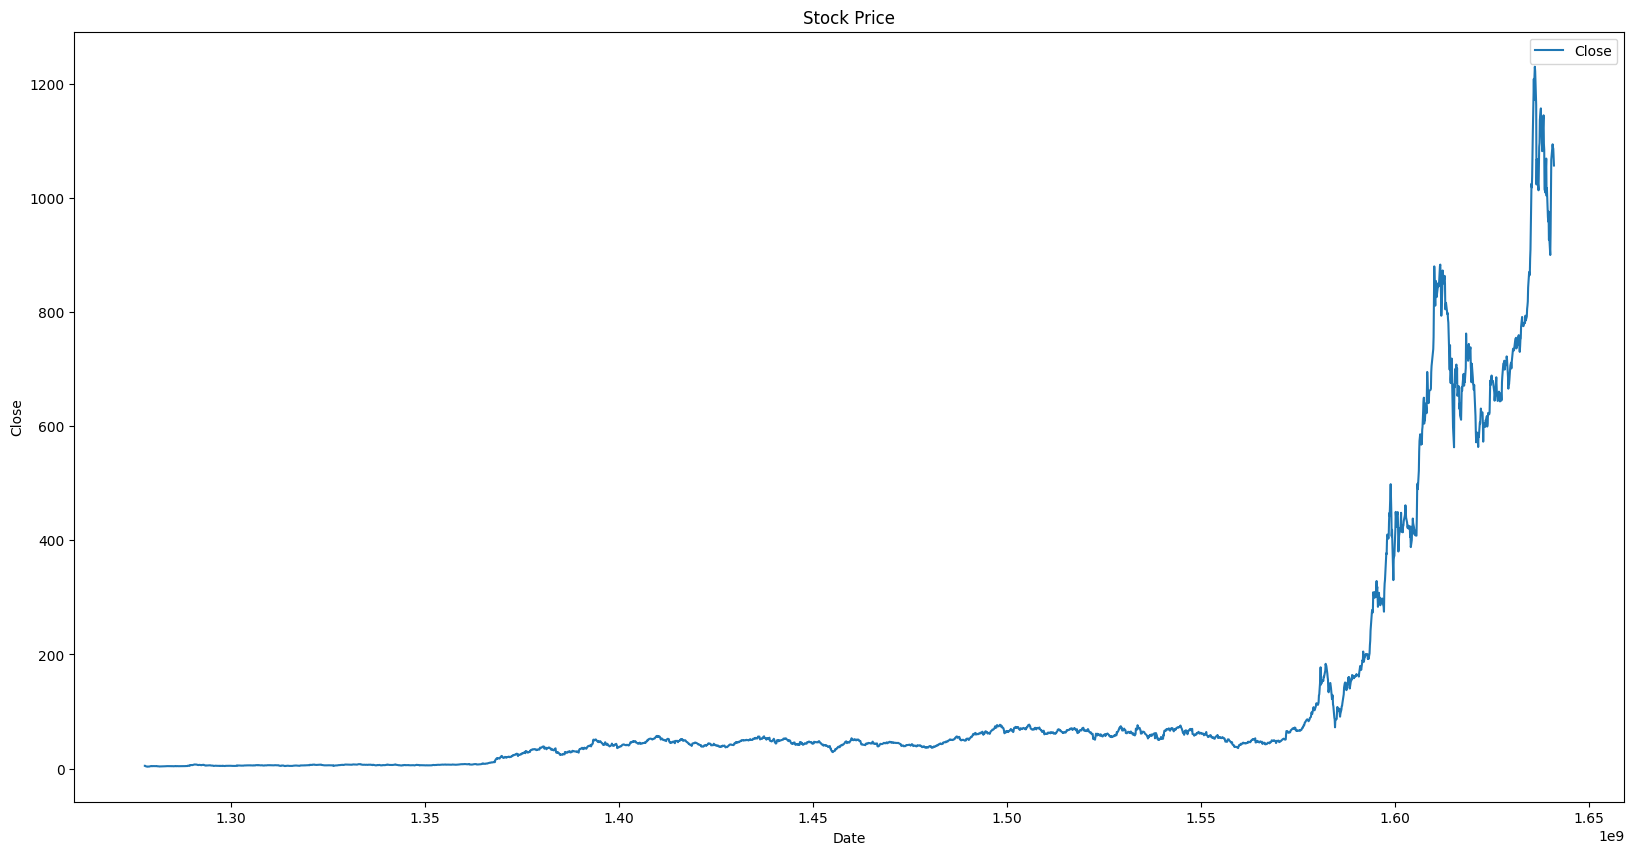

In [7]:
utils.plot_line_chart(train_data, "Date", model_parameters["target"], "Date", model_parameters["target"], "Stock Price")


In [8]:
# ARIMA
# Ref: https://github.com/h2oai/h2o-tutorials/blob/master/best-practices/forecasting/Multi%20group%20TS%20Forecasting%20with%20H2O-3.ipynb

if model_name == "autoreg":
    model = train.train_ar(train_data, model_parameters)
    preds = evaluate.get_forecast(model, test_data.index.min(), test_data.index.max())


In [9]:
# Autoregressive Integrated Moving Average (ARIMA)
# TODO evaluate every step using true values of previous steps
if model_name == "arima":
    model = train.train_arima(train_data, model_parameters)
    preds = evaluate.get_forecast(model, test_data.index.min(), test_data.index.max())


In [10]:
# XGBoost - Forecasting as a Regression task

if model_name == "xgboost":
    model = train.train_xgboost(train_data, model_parameters)
    preds = model.predict(test_data[model_parameters["feature_names"]])


In [11]:
# Get mean squared error on test data
mse = evaluate.get_mse(test_data[model_parameters["target"]], preds)


MSE: 3298.9974444014456 and RMSE: 57.4368996760919


In [12]:
# Save model and results
utils.save_model(model, None, model_parameters, C.MODEL_DIR, model_name, is_h2o=False)


Saved model and data at models/xgboost_v1


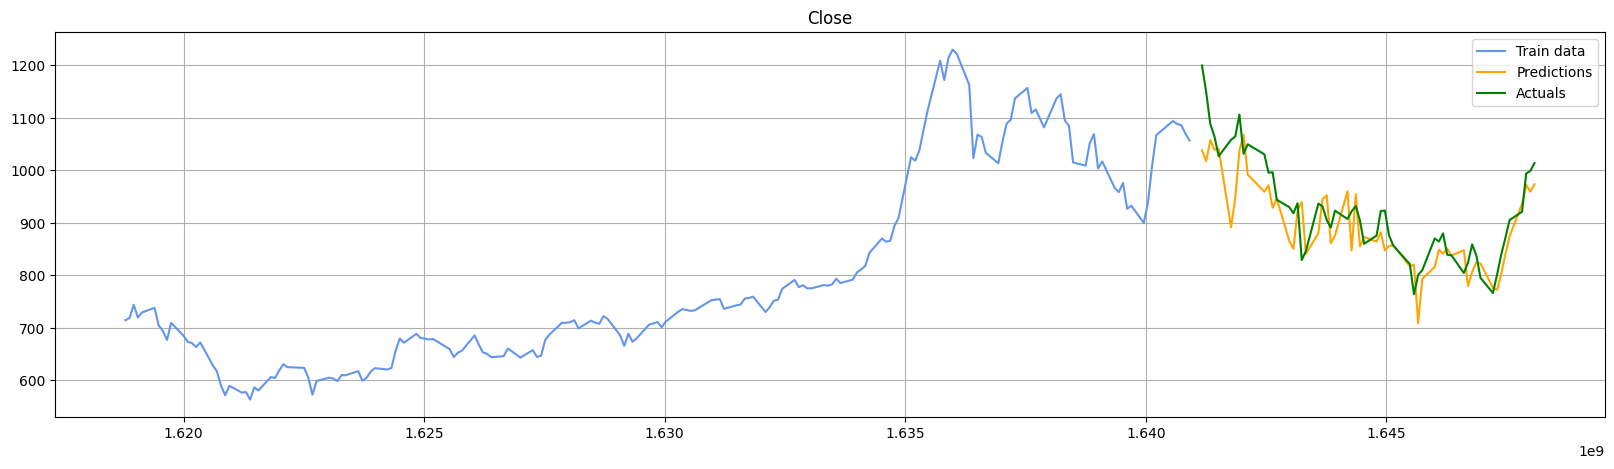

In [13]:
utils.plot_forecast(train_data[-180:], test_data, preds, "Date", model_parameters["target"])


In [14]:
# Shutdown H2O
h2o.cluster().shutdown()
